In [18]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import heapq
# from sklearn.metrics import confusion_matrix
# # from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import precision_score
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score 
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from sklearn.metrics import multilabel_confusion_matrix
# from skimage.filters import threshold_otsu
# similarity_case_1_p = '../../../results/RF/simliarity_measure/case_1_ref_mask_similarity_measure.tif'
# similarity_case_2_p = '../../../results/RF/simliarity_measure/case_2_ref_mask_similarity_measure.tif'
# similarity_case_3_p = '../../../results/RF/simliarity_measure/case_3_ref_mask_similarity_measure.tif'
binary_change_map = '../../../results/RF/binary_change_D/change_map_case_1.tif'
# similarity_change_map = '../../../results/RF/simliarity_measure/optimal_threshold/sim-change_map_case_1.tif'
# source_proba_distr = '../../../results/RF/simliarity_measure/2018_rf_model_1.npy'
# target_proba_distri = '../../../results/RF/simliarity_measure/2019_rf_model_1.npy'

# gt_source_path  = '../../../data/rasterized_samples/2018_rasterizedImage.tif'
# gt_target_path = '../../../data/rasterized_samples/2019_rasterizedImage.tif'
# pred_source_path = '../../../results/RF/2018_rf_case_2_map.tif'
# pred_target_path = '../../../results/RF/2019_rf_case_3_map.tif'
certainty_case_1 = '../../../results/RF/simliarity_measure/certainty/2018_certainty_1.tif'
# certainty_case_1 = '../../../results/RF/simliarity_measure/certainty/2018_certainty_1.tif'
similarity_change = '../../../results/RF/simliarity_measure/optimal_threshold/sim-change_map_case_1.tif'

In [31]:
with rasterio.open(binary_change_map) as src:
    hard_ = src.read(1).astype('int')
    profile = src.profile
    height, width = src.shape
    nodata = src.nodata

soft_ = rasterio.open(similarity_change).read(1).astype('int')
certainty_ = rasterio.open(certainty_case_1).read(1)

In [32]:
mask = hard_ != nodata

In [33]:
def mask_and_extract(array, mask_array):
        array = np.ma.masked_array(array, mask=True)
        array.mask[mask_array] = False
        array_value = np.ma.compressed(array)
        return array_value

In [34]:
hard_ = mask_and_extract(hard_, mask)
soft_ = mask_and_extract(soft_, mask)
certainty_ = mask_and_extract(certainty_, mask)

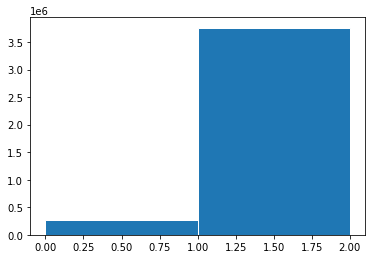

In [74]:
plt.hist(agree_, bins=2, ec='white')
plt.show()

In [76]:
cat1 = np.where((hard_ == 1) & (soft_ == 1)) =

In [73]:
agree_ = np.zeros_like(soft_)
agree_[(hard_ == 1) | (soft_ == 1) & (hard_ == 4) | (soft_ == 4)] = 1
agree_[(soft_ == 3) | (hard_ == 2) & (hard_ == 3) & (soft_ == 2)] = 2
# agree_[(hard_ == 3) & (soft_ == 2)] = 2

In [70]:
np.unique(agree_)

array([1, 2])

In [62]:
np.unique(hard_)

array([1, 2, 3, 4])

In [63]:
np.unique(soft_)

array([1, 2, 3, 4])

In [8]:
# # agreement between soft and hard detection and they are correct
# agree_ = np.zeros_like(hard_)
# agree_[(hard_ == 1) & (soft_ == 1) | (hard_ == 4) & (soft_ == 4)] = 1 #both correct
# # both incorrect -- This returns nothing because there is no intersecting pixel btw the two
# agree_[(hard_ == 2) & (soft_ == 3) | (hard_ == 3) & (soft_ == 2)] = 2 
# agree_[(hard_ == 1) & (soft_ == 2) | (hard_ == 4) & (soft_ == 3)] = 3 # hard correct and soft not
# agree_[(hard_ == 4) & (soft_ == 2) | (hard_ == 1) & (soft_ == 3)] = 3 # hard correct and soft not
# agree_[(hard_ == 2) & (soft_ == 1) | (hard_ == 3) & (soft_ == 4)] = 4 # hard incorrect and soft is
# agree_[(hard_ == 2) & (soft_ == 4) | (hard_ == 3) & (soft_ == 1)] = 4 # hard incorrect and soft is

In [9]:
# fiability measure histogram
def _mask(cert, agree, value):
    cert = np.ma.masked_array(cert, mask=True)
    cert.mask[agree == value] = False
    return cert.compressed()

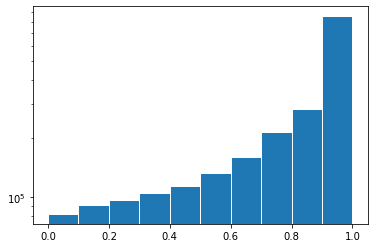

In [16]:
cert_1 = _mask(certainty_, hard_, 1)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

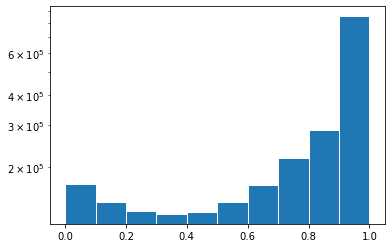

In [17]:
cert_1 = _mask(certainty_, soft_, 1)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

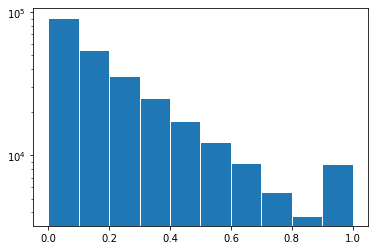

In [10]:
cert_1 = _mask(certainty_, hard_, 2)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

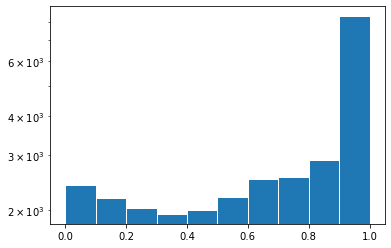

In [11]:
cert_1 = _mask(certainty_, soft_, 2)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

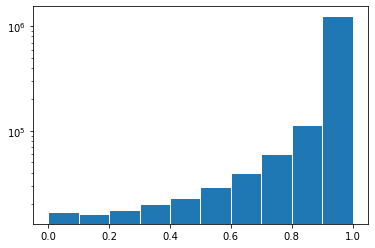

In [12]:
cert_1 = _mask(certainty_, soft_, 4)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

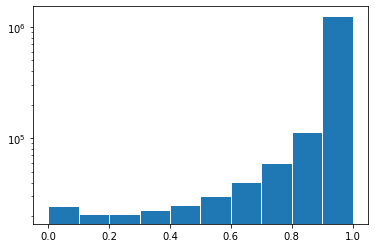

In [13]:
cert_1 = _mask(certainty_, hard_, 4)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

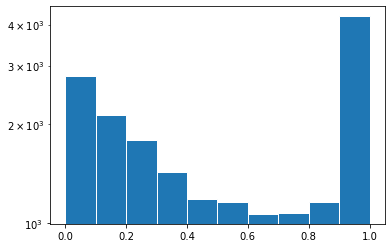

In [14]:
cert_1 = _mask(certainty_, hard_, 3)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

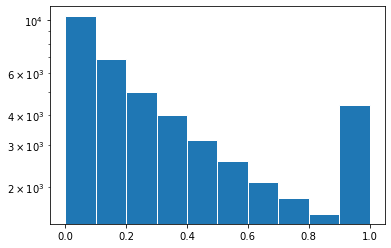

In [15]:
cert_1 = _mask(certainty_, soft_, 3)
plt.hist(cert_1, bins=10, label='Fiability distribution', ec='white', log=True)
plt.show()

In [16]:
def plot_hist(data, domain):
    plt.hist(data, bins=10, label='Fiability distribution', ec='white', log=True)
    plt.xlabel('certainty')
    plt.ylabel('pixels')
    plt.legend(loc="upper left")
    # plt.savefig(os.path.join(outdir, domain+'_fiability_case_' +str(i)+'.png'))
    plt.show()
    # plt.close()

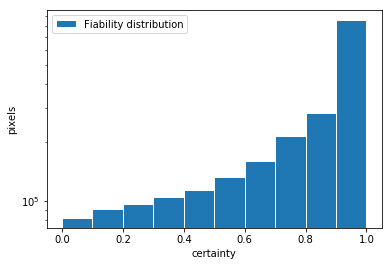

In [18]:
for i in range(1, 5):
    cert = _mask(certainty_, hard_, i)
    plot_hist(cert, 'source')
    # plt.hist(cert, bins=10, label='Fiability distribution', ec='white')
    # plt.hist(cert, bins=10, label='Fiability distribution', ec='white')
    # plt.savefig("fig"+str(i)+".png")
    # plt.xlabel('certainty')
    # plt.ylabel('pixels')
    # plt.legend(loc="upper left")
    # plt.show()
    # plt.close()
    break

In [ ]:
gt_mask_nodata = (gt_source_ != 0) & (gt_target_ != 0)

In [ ]:
gt_mask_nodata

array([False, False, False, ..., False, False, False])

In [ ]:
def mask_and_extract(array, mask_array):
    array = np.ma.masked_array(array, mask=True)
    array.mask[mask_array] = False
    array_value = np.ma.compressed(array)
    return array_value
gt_source_ = mask_and_extract(gt_source_, gt_mask_nodata)
gt_target_ = mask_and_extract(gt_target_, gt_mask_nodata)
pred_source_ = mask_and_extract(pred_source_, gt_mask_nodata)
pred_target_ = mask_and_extract(pred_target_, gt_mask_nodata)

In [ ]:
# mcm = multilabel_confusion_matrix(df['gt_change'], df['pred_change'])

In [ ]:
# mcm

In [ ]:
df = pd.DataFrame({'gt_source': gt_source_, 'gt_target': gt_target_, 'pred_source': pred_source_, 'pred_target': pred_target_})

In [ ]:
dict_={1: 'Dense built-up area',
2: 'Diffuse built-up area',
 3: 'Industrial and commercial areas',
 4: 'Roads',
 5: 'Oilseeds (Rapeseed)',
 6: 'Straw cereals (Wheat, Triticale, Barley)',
 7: 'Protein crops (Beans / Peas)',
 8: 'Soy',
 9: 'Sunflower',
 10: 'Corn',
 12: 'Tubers/roots',
 13: 'Grasslands',
 14: 'Orchards and fruit growing',
 15: 'Vineyards',
 16: 'Hardwood forest',
 17: 'Softwood forest',
 18: 'Natural grasslands and pastures',
 19: 'Woody moorlands',
 23: 'Water'}

In [ ]:
import time
start_time =time.time()
# label = ['Dense built-up area', 'Diffuse built-up area', 'Industrial and commercial areas', 'Roads', 'Oilseeds (Rapeseed)', 'Straw cereals (Wheat, Triticale, Barley)', 'Protein crops (Beans / Peas)', 'Soy', 'Sunflower', 'Corn',  'Tubers/roots', 'Grasslands', 'Orchards and fruit growing', 'Vineyards', 'Hardwood forest', 'Softwood forest', 'Natural grasslands and pastures', 'Woody moorlands', 'Water']
df['gt_source'] = df['gt_source'].map(dict_)
df['gt_target'] = df['gt_target'].map(dict_)
df['pred_source'] = df['pred_source'].map(dict_)
df['pred_target'] = df['pred_target'].map(dict_)
print(" %s minute" % str((time.time() - start_time)/60))

 0.010826957225799561 minute


In [ ]:
import time
start_time =time.time()
df['gt_change']= df.apply(lambda x: str(x['gt_source']) + '-' + str(x['gt_target']), axis=1)
df['pred_change']= df.apply(lambda x: str(x['pred_source']) + '-' + str(x['pred_target']), axis=1)
print(" %s minutes" % str((time.time() - start_time)/60))

 3.4293226917584736 minutes


In [ ]:
cm = pd.crosstab(df['gt_change'], df['pred_change'], rownames=['Ground Truth'], colnames=['Prediction'])

In [ ]:
cm_recall = cm.apply(lambda x: x/x.sum(), axis=1)

In [72]:
cm_recall.to_csv('nn.csv')

In [69]:
cm_re[[0]]

Ground Truth
Corn-Corn    [Corn-Corn]
dtype: object

In [7]:
# df['gt_change']= df.apply(lambda x: str(x['gt_source']) + '-' + str(x['gt_target']), axis=1)
# df['pred_change']= df.apply(lambda x: str(x['pred_source']) + '-' + str(x['pred_target']), axis=1)

In [ ]:
def changeErrorCheck(
    case,
    gt_source,
    gt_target,
    pred_source,
    pred_target,
    outdir
    ):
    # read rasters
    gt_source_ = rasterio.open(gt_source).read(1).flatten().astype('int')
    gt_target_ = rasterio.open(gt_target).read(1).flatten().astype('int')
    pred_source_ = rasterio.open(pred_source).read(1).flatten()
    pred_target_ = rasterio.open(pred_target).read(1).flatten()
    
    gt_mask_nodata = (gt_source_ != 0) & (gt_target_ != 0)
    
    def mask_and_extract(array, mask_array):
        array = np.ma.masked_array(array, mask=True)
        array.mask[mask_array] = False
        array_value = np.ma.compressed(array)
        return array_value

    gt_source_ = mask_and_extract(gt_source_, gt_mask_nodata)
    gt_target_ = mask_and_extract(gt_target_, gt_mask_nodata)
    pred_source_ = mask_and_extract(pred_source_, gt_mask_nodata)
    pred_target_ = mask_and_extract(pred_target_, gt_mask_nodata)
    
    # class label
    dict_={1: 'Dense built-up area',
    2: 'Diffuse built-up area',
     3: 'Industrial and commercial areas',
     4: 'Roads',
     5: 'Oilseeds (Rapeseed)',
     6: 'Straw cereals (Wheat, Triticale, Barley)',
     7: 'Protein crops (Beans / Peas)',
     8: 'Soy',
     9: 'Sunflower',
     10: 'Corn',
     12: 'Tubers/roots',
     13: 'Grasslands',
     14: 'Orchards and fruit growing',
     15: 'Vineyards',
     16: 'Hardwood forest',
     17: 'Softwood forest',
     18: 'Natural grasslands and pastures',
     19: 'Woody moorlands',
     23: 'Water'}
    
    df = pd.DataFrame({'gt_source': gt_source_, 'gt_target': gt_target_, 'pred_source': pred_source_, 'pred_target': pred_target_})
    # rename class to label
    df['gt_source'] = df['gt_source'].map(dict_)
    df['gt_target'] = df['gt_target'].map(dict_)
    df['pred_source'] = df['pred_source'].map(dict_)
    df['pred_target'] = df['pred_target'].map(dict_)
    
    
    df['gt_change']= df.apply(lambda x: str(x['gt_source']) + '-' + str(x['gt_target']), axis=1)
    df['pred_change']= df.apply(lambda x: str(x['pred_source']) + '-' + str(x['pred_target']), axis=1)
    
    cm = pd.crosstab(df['gt_change'], df['pred_change'], rownames=['Ground Truth'], colnames=['Prediction'])
    
    cm.to_csv("semantic_change_matrix" + case + '.csv')

if __name__ == '__main__':
    gt_source_path = '../../../data/rasterized_samples/2018_rasterizedImage.tif'
    gt_target_path = '../../../data/rasterized_samples/2019_rasterizedImage.tif'
    
    for case in ['1', '2', '3']:
        pred_source_path = '../../../results/RF/2018_rf_case_'+ case +'_map.tif'
        pred_target_path = '../../../results/RF/2019_rf_case_'+ case +'_map.tif'
        outdir_ = '../../../results/RF/binary_change_D'
        changeErrorCheck(case, gt_source_path, gt_target_path, pred_source_path, pred_target_path, outdir)